In this peroject, I will create a deep learning model that detects the TNt tubes formed in between cells. Below is a berief decsripton of what TNTs are:

"Tunneling nanotubes (TNTs) are elongated structures extending from and connecting cancer cell membranes. They permit the exchange of molecules, vesicles, and mitochondria, as well as genetic and metabolic signals that promote carcinogenesis. Given that they permit intercellular trafficking and communication, TNTs may serve as an important imaging biomarker of cancer cell response vs. resistance to therapy. On fluorescence imaging of cancer cell cultures, TNTs appear to be no thicker than 1 µm and vary in length from 10 to 100+ µm. TNTs can be spotted by a trained eye, but using human experts to obtain an accurate count and location of TNTs is a time-intensive process. A precise quantitative analysis of TNTs could aid in the objective assessment of cancer response to various therapeutic interventions."

In this project I was provided with only one image of cells of size 6278*4690. Image was labeled manually by 3 independent trained doctors with yellow lines, representing TNTs. I will use this image to create a deep learning model that detects the TNT tubes formed in between cells.

To generate training data I will cut image on arbitrary size pieces sliding by X size of pixels on each image, and will label them as TNT or not TNT. I will use this data to train my model. I will use the same function to cut the test image and will use my model to predict the TNTs on the test image. The big part here is to determine the size of the pieces, shifting step size and logic to label them as TNT or not TNT.

# Image Preprocessing

In [21]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import cv2
import os
from pathlib import Path
from PIL import Image, ImageOps

from scipy import ndimage
import sys
import shutil
import pickle 

from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.xception import Xception 
from keras.applications.xception import preprocess_input

import albumentations as A

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Activation, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from keras.models import load_model
from keras.models import save_model


DATADIR = r'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\Temp Data for P6' 
MAINDIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\P6-DL-TNT-Twitter\TNT Project'
SEED = 1
plt.rcParams['figure.figsize'] = [15, 15]

This is image with labels:

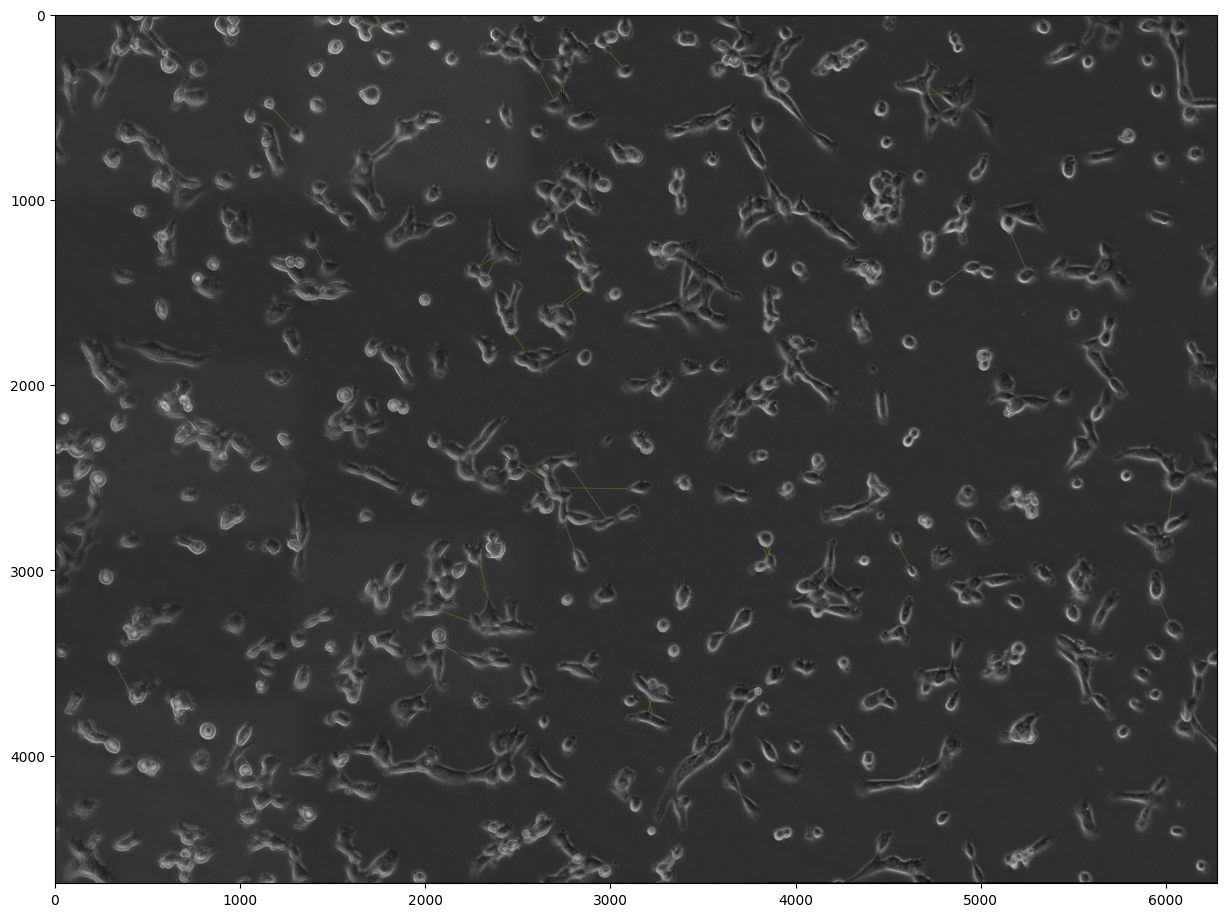

In [3]:
img_array = cv2.imread(os.path.join(MAINDIR,r'm05-label.jpg')) 
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### Cutting and augmenting image

To develop correct function for image generation I will play with parameters of: 
1. Parameters of our mask for identifying yellow TNTs in function cv2.inRange().
2. cv2.treshhold() - to recreate lines of the TNTs.
3. cv2.dilate() - to make the lines thicker and more visible.

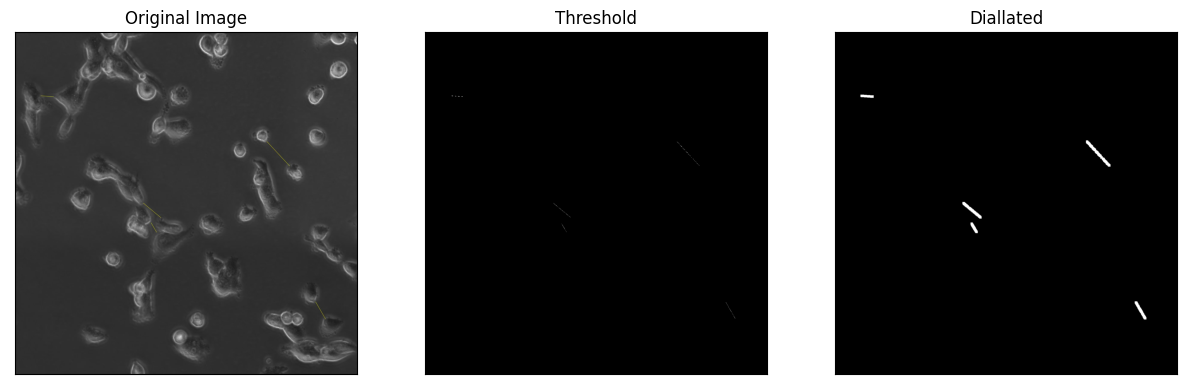

In [4]:
# cut smaller image of size 1600x1600 beginning at (0,0)
img_rgb_1600 = img_rgb[0:1600, 0:1600]
# check if we have yellow pixels in the image
yellow_low = np.array([120, 120, 0])
yellow_high = np.array([255, 255, 100])
mask = cv2.inRange(img_rgb_1600, yellow_low, yellow_high)
_, mask_th = cv2.threshold(mask, 30, 255,cv2.THRESH_BINARY )

mask_th_diallated = cv2.dilate(mask_th, np.ones((3,3), np.uint8), iterations=5)
images = [img_rgb_1600, mask_th, mask_th_diallated]
titles = ['Original Image','Threshold', 'Diallated']
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

* Now when we checked the functional way to process pictures and can clearly see the lines of TNTs, we can start to create functions for image generation.

In [5]:
def cut_image(img, piece_size, shift):
    x = 0
    y = 0
    pieces = []
    while y + piece_size < img.shape[0]:
        while x + piece_size < img.shape[1]:
            pieces.append(img[y:y+piece_size, x:x+piece_size])
            x += shift
        x = 0
        y += shift
    return pieces

In [6]:
def emphasize_TNT(img):
    yellow_low = np.array([120, 120, 0])
    yellow_high = np.array([255, 255, 100])
    mask = cv2.inRange(img, yellow_low, yellow_high)
    _, mask_th = cv2.threshold(mask, 30, 255,cv2.THRESH_BINARY )
    mask_th_diallated = cv2.dilate(mask_th, np.ones((3,3), np.uint8), iterations=5)
    return mask_th_diallated

Now we cut image and emphasize the TNTs.

In [7]:
images_1600 = cut_image(img_rgb, 1600, 50)

In [8]:
tnt_1600 = []
for img in images_1600:
    emp_img = emphasize_TNT(img)
    tnt_1600.append(emp_img)

In [9]:
len (tnt_1600)

5828

### Labeling the images

Now we will develop function to classify images in rule based way, with and without TNTs. To be able to create training labeled set of pictures.  
* Preliminary logic :
1. If no TNT in a picture - then label it as 0.
2. If TNT in the edge of the picture - then label it as 0.
3. If TNT not on the edge, but fully visible - then label it as 1. 
4. If some TNTs on the edge and some not - then label it as 2. 

It is quite hard to manually find the case N3 from above, so I will picture only cases 1,2,4.

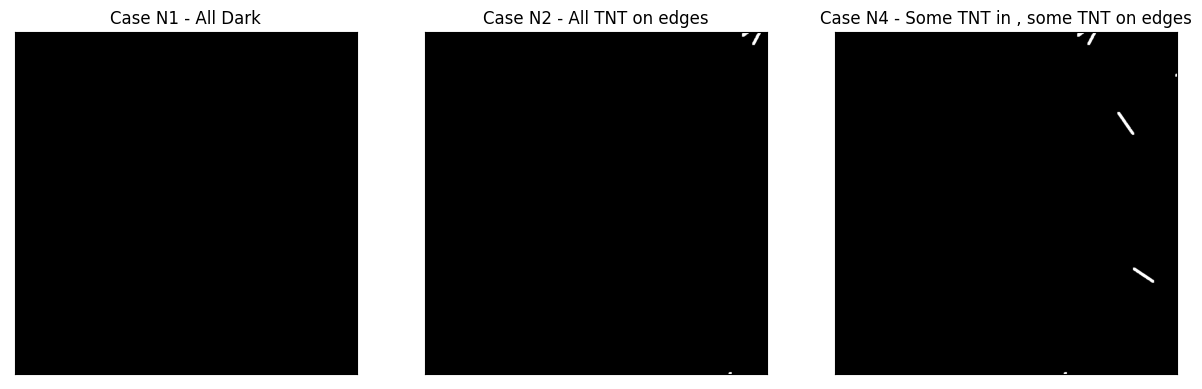

In [10]:
images_1600_to_plot = [tnt_1600[2550], tnt_1600[2554], tnt_1600[2561]]
images_1600_to_plot_titles = ['Case N1 - All Dark', 'Case N2 - All TNT on edges', 'Case N4 - Some TNT in , some TNT on edges']
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(images_1600_to_plot[i], 'gray')
    plt.title(images_1600_to_plot_titles[i])
    plt.xticks([]), plt.yticks([])

After contemplating on the logic, I decided to add a frame into the logic. There is why : 
* Frame of 150 pix is necessary for the system to be able to see cells attached to TNT, not only TNT itself. So 150 pixels will give system better view of the picture and potentially will help to classify it better.  

This is how my mask for the logic looks like:

<center><img src="..\TNT Project\Logic Mask Representation.bmp" alt="Alternative text" /></center>

* Here is a exhaustive number of cases considering that we have Image center, Frame and border(1 pixel line on the edge of center image).  

* Where 0 and 1 on a picture represent whether TNT is on 1 - Frame, 2 - Center, 3 - Border. And big numbers represent the class of the picture.
  
* We will use only 1 and 0 clases to spare model from learning parts of cells which are out of the picture.  

<center><img src="..\TNT Project\Cases.bmp" alt="Alternative text" /></center>

Now we create funtion to label images in rule based way using above logic.

In [11]:
def check_tnt(img, frame_size):
    img_center = img[frame_size:-frame_size, frame_size:-frame_size]
    img_inside_center_1pix = img[frame_size+1:-frame_size-1, frame_size+1:-frame_size-1]

    # get sum of the whole image
    img_sum = np.sum(img)
    # get sum of pixels outside of the center minus summs of corners because we have 4 corners
    img_frame_sum = np.sum(img[0:frame_size, :]) + np.sum(img[-frame_size:, :]) + np.sum(img[:, 0:frame_size]) + np.sum(img[:, -frame_size:]) \
    - np.sum(img[0:frame_size, 0:frame_size]) - np.sum(img[0:frame_size, -frame_size:]) - np.sum(img[-frame_size:, 0:frame_size]) - np.sum(img[-frame_size:, -frame_size:])

    # get sum of pixels inside the center
    img_center_sum = np.sum(img_center)
    # get sum of pixels inside the center 1 pixel
    img_inside_center_1pix_sum = np.sum(img_inside_center_1pix)
    # Calculate sum of 1 pix wide border inside the center
    img_border_sum = np.int64(img_sum) - np.int64(img_frame_sum) - np.int64(img_inside_center_1pix_sum)

    # -------------------------- For Debugging  BEGINS--------------------------
    # print (img_sum/255,'  - img_sum number of white pixels')
    # print(img_center_sum/255,' - img_center_sum number of white pixels ')
    # print(img_frame_sum/255,' - img_frame_sum number of white pixels ')
    # print(img_inside_center_1pix_sum/255,' - img_inside_center_1pix_sum number of white pixels ')
    # print(img_border_sum/255,' - img_border_sum number of white pixels ')

    # images_to_show = [img, img_center]
    # titles_to_show = ['Original Image', 'Center']
    # for i in range(2):
    #     plt.subplot(1, 2, i+1), plt.imshow(images_to_show[i], 'gray')
    #     plt.title(titles_to_show[i])
    #     plt.xticks([]), plt.yticks([])
    # -------------------------- For Debugging  END --------------------------
    if ((img_sum == 0) or                                                           # case 1
            (img_frame_sum > 0 and img_center_sum == 0 and img_border_sum == 0) or  # case 2
            (img_frame_sum == 0 and img_center_sum == 0 and img_border_sum > 0) or  # case 4
            (img_frame_sum > 0 and img_center_sum == 0 and img_border_sum > 0)):    # case 6
        return 0
    elif ((img_frame_sum == 0 and img_center_sum > 0 and img_border_sum == 0) or    # case 3
          (img_frame_sum == 0 and img_center_sum > 0 and img_border_sum > 0)):      # case 5
        return 1
    else:
        return 2 # case 6 and 7
    

Pic Label:  2


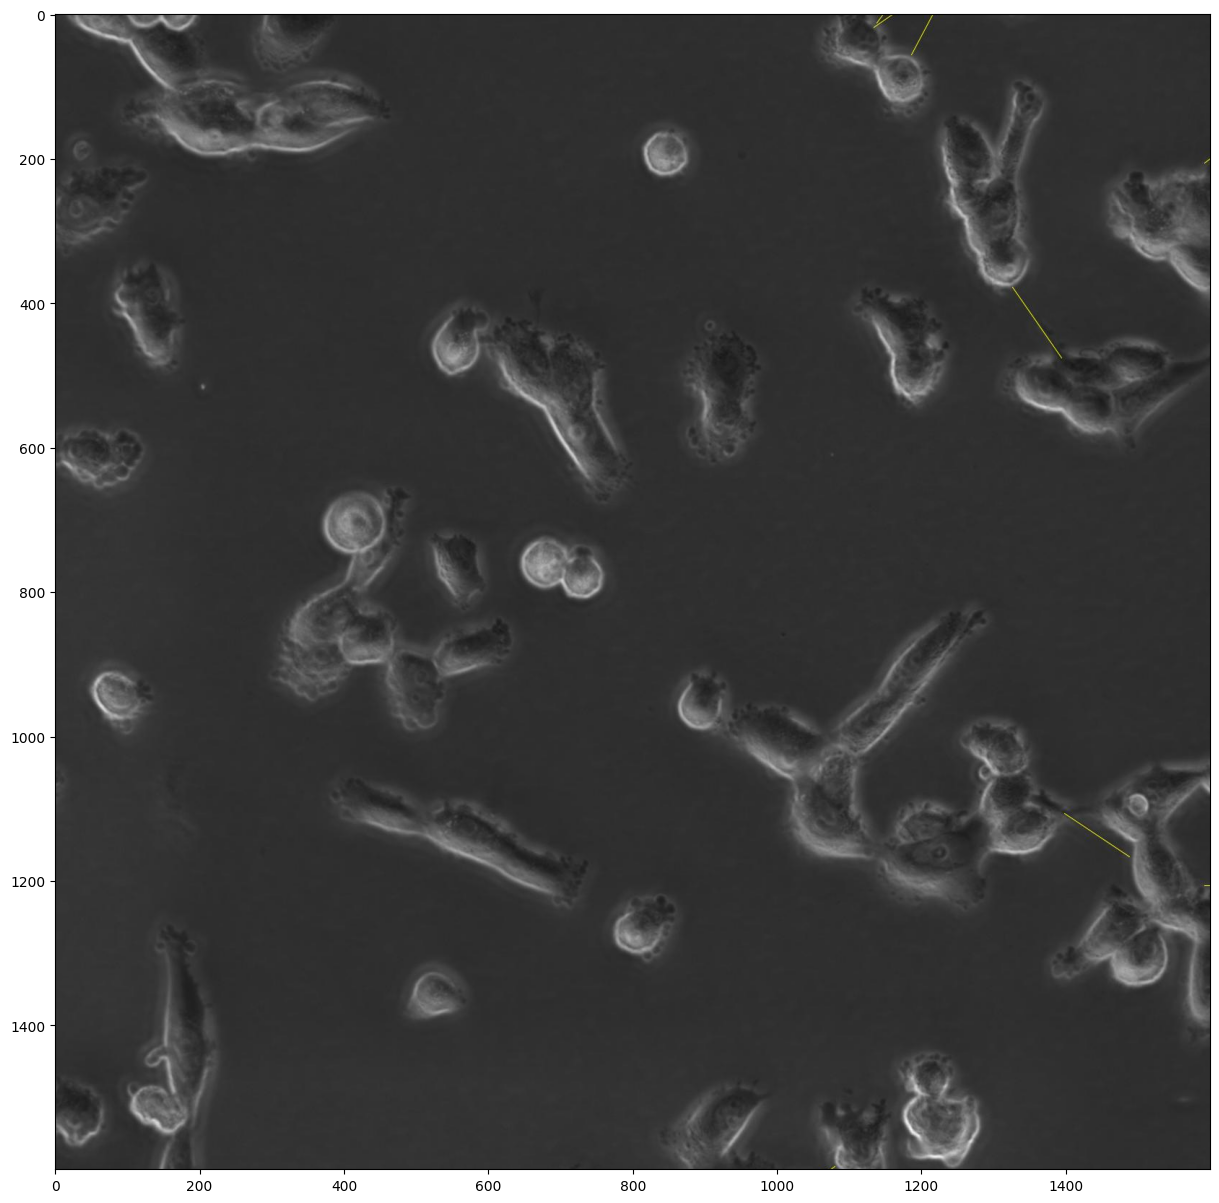

In [12]:
# quick tests
plt.imshow(images_1600[2561])
print('Pic Label: ', check_tnt(tnt_1600[2561],150))

* Now we try different sizes of cutting main image and see how many of each class we have in each size.
#### We have : 
1. function to cut images into smaller pieces - cut_image()
2. function to create masks for images with emphasized TNTs - emphasize_TNT()
3. function to label images with TNTs - check_tnt()

4. Different sizes of images
5. Differnt sizes of shifts

We need to create a table with different sizes of images starting from 270x270 to 1600-1600 and shift of 50/1600=0.031 pixels. Where we go down from 1600x0.8 in size to get to 270 pixels approximatelly.
The outcomig DF will have  columns: size,shift, number of images with label 0, number of images with label 1, number of images with label 2. I hope to be able to choose best size of images and shift for image generation. We can also go back to this and get some different shifts and sizes to see how the model will perform.

In [13]:
def get_sizes(max_size, stop_size, step):
    size = np.array(max_size)
    sizes = [size]
    while size[0] > stop_size:
        size = size*step
        sizes.append(size)

    sizes = [size.astype(int) for size in sizes]
    return sizes

sizes_shifts = get_sizes((1600,50), 270, 0.8)
sizes = [size[0] for size in sizes_shifts]
shifts = [size[1] for size in sizes_shifts]

size_shift_dict = dict(zip(sizes, shifts))
print(size_shift_dict)

{1600: 50, 1280: 40, 1024: 32, 819: 25, 655: 20, 524: 16, 419: 13, 335: 10, 268: 8}


* cut_image(img, piece_size, shift) # returns list of images  
* emphasize_TNT(img)                # returns image  
* check_tnt(img, frame_size)        # returns 0, 1 or 2  

In [14]:
def find_best_size(img, size_shift_dict):
    df_by_labels = pd.DataFrame(columns=['Size', 'Shift', 'Number of label 0', 'Number of label 1', 'Number of label 2'])

    for size in size_shift_dict:
        pieces = cut_image(img, size, size_shift_dict[size])
        print('Size: ', size)
        print('Number of pieces: ', len(pieces))
        label_0 = 0
        label_1 = 0
        label_2 = 0
        for i,piece in enumerate(pieces):
            emp_img = emphasize_TNT(piece)
            tnt = check_tnt(emp_img, 150)

            if tnt == 0:
                label_0 += 1
            elif tnt == 1:
                label_1 += 1
            else:
                label_2 += 1
            
            if i%1000 == 0:
                print(i, 'pieces done of ', len(pieces), ' of size ', size)   
                
        df_temp = pd.DataFrame([[size, size_shift_dict[size], label_0, label_1, label_2]], columns=['Size', 'Shift', 'Number of label 0', 'Number of label 1', 'Number of label 2'])
        df_by_labels = pd.concat([df_by_labels, df_temp], ignore_index=True)
        return df_by_labels
    
# df_by_labels = find_best_size(img_rgb, size_shift_dict)

In [15]:
# pickle the dataframe
# df_by_labels.to_pickle(r'..\\TNT Project\\df_sizez_by_labels.pkl')

# load the dataframe
df_by_labels = pd.read_pickle(os.path.join(MAINDIR,r'df_sizez_labels.pkl'))
df_by_labels

,Size,Shift,Number of label 0,Number of label 1,Number of label 2
0,1600,50,513,934,4381
1,1280,40,2447,1434,6869
2,1024,32,7982,2631,8362
3,819,25,21376,3043,9526
4,655,20,44441,2516,10007
5,524,16,83084,1458,9418
6,419,13,140814,227,7338
7,335,10,255969,1,3450
8,268,8,415856,0,0


* As we can see from the table, the most of the label 1 images were captured by 819x819 images with shift of 25 pixels. Meaning that the most full size TNT(not on the edges) were captured on this size/shift.   So we will use this size of images and shift for image generation.

In [16]:
# Creating df with Picture names and labels
data = {'Pic_name': [], 'Label': []}
pieces = cut_image(img_rgb, 819, 25)
for i, image in enumerate(pieces):
    emp_img = emphasize_TNT(image)
    tnt_label = check_tnt(emp_img, 150)
    pic_name = f'{819}-{25}-pic_{i}_label_{tnt_label}.jpg'
    data['Pic_name'].append(pic_name)
    data['Label'].append(tnt_label)

    if i%5000 == 0:
        print(i, 'pieces done of ', len(pieces))

df = pd.DataFrame(data)

0 pieces done of  33945
5000 pieces done of  33945
10000 pieces done of  33945
15000 pieces done of  33945
20000 pieces done of  33945
25000 pieces done of  33945
30000 pieces done of  33945


In [17]:
df.tail(5)

,Pic_name,Label
33940,819-25-pic_33940_label_0.jpg,0
33941,819-25-pic_33941_label_0.jpg,0
33942,819-25-pic_33942_label_0.jpg,0
33943,819-25-pic_33943_label_0.jpg,0
33944,819-25-pic_33944_label_0.jpg,0


In [18]:
df['Label'].value_counts()

0    21376
2     9526
1     3043
Name: Label, dtype: int64

#### If we discard all instances whenre TNT is on frame (label 2) we will have 2 classes of images: with TNT and without TNT. We will use this to train our model.
1. We will cut our image without yellow visible lines into our images for training.
2. We will Augment minor class of images "1" using albumentations module to balance dataset.

* Here we have an unbalanced dataset. We have to deal wit this.   

In [19]:
df_no_2 = df[df['Label'] != 2].copy(deep=True)
df_no_2['Label'].value_counts()

0    21376
1     3043
Name: Label, dtype: int64

#### 1. Create images

In [20]:
# Load picture without yellow lines. TNT Project\m05.jpg,  cut it to pieces and save them
img_rgb_no_lines = cv2.imread(os.path.join(MAINDIR,r'm05.jpg'), cv2.IMREAD_COLOR)
pieces = cut_image(img_rgb_no_lines, 819, 25)
file_names = df['Pic_name'].values

print (len(pieces), len(file_names))

for i, image in enumerate(pieces):
    full_path = os.path.join(DATADIR, file_names[i])
    
    if not os.path.exists(full_path):
        cv2.imwrite(full_path, image)
    
        if i%5000 == 0:
            print(i, 'pieces done of ', len(pieces))

33945 33945


#### 2. Preparing inputs for the model
1. Create augmented images of minor class.

In [21]:
def count_files_in_dir(path):
    label_1_count = 0
    label_0_count = 0
    for file in os.listdir(path):
        if 'label_1' in file:
            label_1_count += 1
        elif 'label_0' in file:
            label_0_count += 1
        else:
            pass
    return (label_1_count, label_0_count)

In [22]:
transform = A.Compose([
            A.Flip(p=0.5),
            A.GridDistortion(p=0.5,num_steps=5, distort_limit=0.3),
            A.HorizontalFlip (p=0.5),
            A.VerticalFlip (p=0.5),
            A.OpticalDistortion(p=0.5, distort_limit=0.3, shift_limit=0.3),
            A.RandomRotate90(p=0.5),
            A.SafeRotate (p=0.5, border_mode=1)
        ]) 

def generate_pics_for_minor_class(df_with_names, path, transform):
    ratio = count_files_in_dir(path)[0] / count_files_in_dir(path)[1]
    i = 0
    r = 0
    while ratio < 1:

        if i == df_with_names.shape[0]:
            i = 0
            r += 1

        file_name = df_with_names['Pic_name'].values[i]
        if not os.path.exists(os.path.join(path, f'aug_{r}-{file_name}')):
            image_path = os.path.join(path, file_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            transformed = transform(image=image)
            transformed_image = transformed["image"]

            cv2.imwrite(os.path.join(path, f'aug_{r}-{file_name}'), transformed_image)

        ratio = count_files_in_dir(path)[0] / count_files_in_dir(path)[1]
        if i%1000 == 0:
            print(ratio)

        i += 1
        

generate_pics_for_minor_class(df_no_2[df_no_2['Label'] == 'TNT'], DATADIR, transform)

2. Create Image iterators from balanced dataset.

In [23]:
# add filenames from the directory to the dataframe with labels depending on file name
df_inputs = pd.DataFrame({'Pic_name': os.listdir(DATADIR)})
df_inputs['Label'] = df_inputs['Pic_name'].apply(lambda x: x[-5:-4])
df_inputs = df_inputs[df_inputs['Label'] != '2'].copy(deep=True)
df_inputs['Label'] = df_inputs['Label'].replace({'0': 'No TNT', '1': 'TNT'})
df_inputs['Label'].value_counts()

No TNT    21376
TNT       21376
Name: Label, dtype: int64

Now we have balanced dataset. 

1. Creating data generators for training and validation for Xception model - transfer learning.
2. Creating data generators for training and validation for custom model.

In [24]:
datagen_Xception = ImageDataGenerator( 
                                validation_split=0.2,
                                preprocessing_function=preprocess_input)
datagen_my_model = ImageDataGenerator( 
                                rescale=1./255,
                                validation_split=0.2)

In [25]:
# for Xception
train_iterator_Xception=datagen_Xception.flow_from_dataframe(
                                                dataframe=df_inputs,
                                                directory=DATADIR,
                                                x_col="Pic_name",
                                                y_col="Label",
                                                subset="training",
                                                batch_size=8,
                                                seed=SEED,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(819,819))

valid_iterator_Xception=datagen_Xception.flow_from_dataframe(
                                                dataframe=df_inputs,
                                                directory=DATADIR,
                                                x_col="Pic_name",
                                                y_col="Label",
                                                subset="validation",
                                                batch_size=8,
                                                seed=SEED,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(819,819))

# for my own model
train_iterator_my_model=datagen_my_model.flow_from_dataframe(
                                                dataframe=df_inputs,
                                                directory=DATADIR,
                                                x_col="Pic_name",
                                                y_col="Label",
                                                subset="training",
                                                batch_size=32,
                                                seed=SEED,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(819,819))

valid_iterator_my_model=datagen_my_model.flow_from_dataframe(
                                                dataframe=df_inputs,
                                                directory=DATADIR,
                                                x_col="Pic_name",
                                                y_col="Label",
                                                subset="validation",
                                                batch_size=32,
                                                seed=SEED,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(819,819))

Found 34202 validated image filenames belonging to 2 classes.
Found 8550 validated image filenames belonging to 2 classes.
Found 34202 validated image filenames belonging to 2 classes.
Found 8550 validated image filenames belonging to 2 classes.


#### 3. Learning with my own model

In [26]:
earlystop = EarlyStopping(  patience=4,         # Number of epochs with no improvement after which training will be stopped.
                            monitor="val_loss", # Quantity to be monitored.
                            verbose=1)

In [27]:
model = Sequential()
# Layer 1
model.add(Conv2D(64, (5, 5), input_shape=(819,819,3))) # Window size is 3x3. Input shape is the shape of the image. We are using 64 filters.
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
# Layer 2
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
# Layer 3
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32)) # Because Dese needs 1D input, we need to flatten the data first.
# Output Layer
model.add(Dense(2)) # Output layer
model.add(Activation('softmax')) # Activation Function ( However, comes with layers) . We use sigmoid because we have only 2 classes.


model.compile(loss='binary_crossentropy', # Loss function. We use binary_crossentropy because we have only 2 classes.
              optimizer='adam', # Optimizer. We use adam because it is good default optimizer.
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 815, 815, 64)      4864      
                                                                 
 activation (Activation)     (None, 815, 815, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 271, 271, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 267, 267, 64)      102464    
                                                                 
 activation_1 (Activation)   (None, 267, 267, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 89, 89, 64)       0         
 2D)                                                    

In [28]:
# STEP_SIZE_TRAIN=train_iterator_my_model.n//train_iterator_my_model.batch_size
# STEP_SIZE_VAL=valid_iterator_my_model.n//valid_iterator_my_model.batch_size

# history = model.fit(train_iterator_my_model, validation_data=valid_iterator_my_model, 
#                     batch_size=32, 
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_steps=STEP_SIZE_VAL,
#                     epochs=50,
#                     callbacks=[earlystop],
#                     verbose=1)

In [29]:
# save history
# with open(os.path.join(MAINDIR,r'CNN64x64xDense32model-history'), 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

# save model
# model.save(os.path.join(MAINDIR,r'CNN64x64xDense32model.h5'))

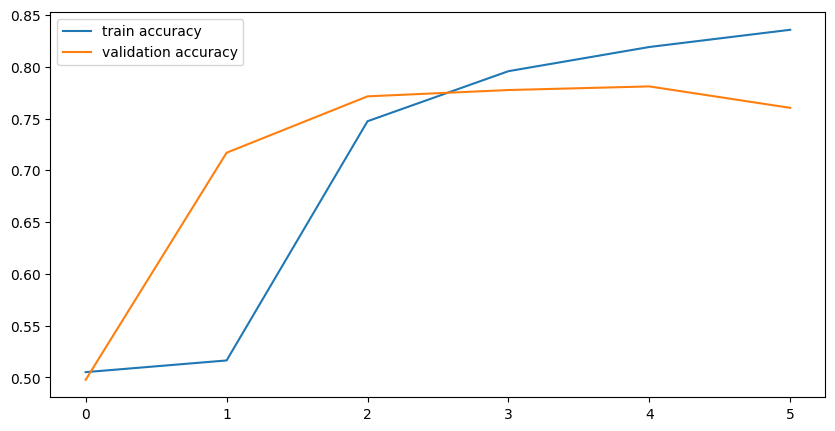

In [30]:
with open(os.path.join(MAINDIR,r'CNN128x64x32xDense32-history'), 'rb') as file_pi:
    history = pickle.load(file_pi)
    
# visualize training history
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

### 3.5 Transfer Learning approach

1. Load Xception model with imagenet weights.

In [31]:
pre_trained_model = Xception(input_shape=(819,819, 3), include_top=False, weights='imagenet')
pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 819, 819, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 409, 409, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 409, 409, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [32]:
pre_trained_model.layers[-6].name

'block14_sepconv1'

2. Add custom layers to the model.

In [33]:
for layer in pre_trained_model.layers[-6:]:
    layer.trainable = False

x = pre_trained_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

earlystop = EarlyStopping(  patience=2,         # Number of epochs with no improvement after which training will be stopped.
                            monitor="val_loss", # Quantity to be monitored.
                            verbose=1)
                            
model = Model(pre_trained_model.input, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

3. Train the model.

In [34]:
# STEP_SIZE_TRAIN=train_iterator_Xception.n//train_iterator_Xception.batch_size
# STEP_SIZE_VAL=valid_iterator_Xception.n//valid_iterator_Xception.batch_size

# history = model.fit(train_iterator_Xception, validation_data=valid_iterator_Xception, 
#                     batch_size=8, 
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_steps=STEP_SIZE_VAL,
#                     epochs=50,
#                     callbacks=[earlystop],
#                     verbose=1)

In [35]:
# # save history
# with open(os.path.join(MAINDIR,r'Xception_custom-history'), 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

# # save model
# model.save(os.path.join(MAINDIR,r'Xception_custom.h5'))

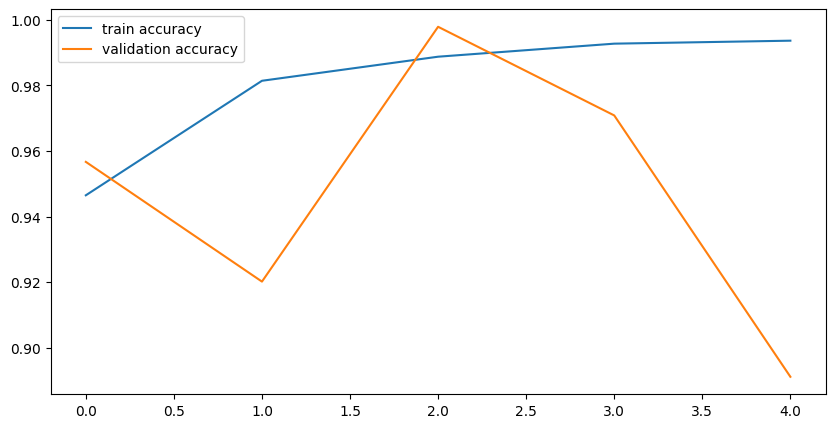

In [36]:
with open(os.path.join(MAINDIR,r'Xception_5batchStop-history'), 'rb') as file_pi:
    history = pickle.load(file_pi)
    
# visualize training history
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

### Predictions

* Preparing image for predictions on trained - labeled images.

In [37]:
def prep_images(img_rgb_with_yellow_lines, img_rgb_no_lines): 
    img_rgb_819 = cut_image(img_rgb_with_yellow_lines, 819, 25)
    img_rgb_no_lines_819 = cut_image(img_rgb_no_lines, 819, 25)
    img_rgb_819_tnt = []
    for img in img_rgb_819:
        emp_img = emphasize_TNT(img)
        img_rgb_819_tnt.append(emp_img)
    return img_rgb_819, img_rgb_no_lines_819, img_rgb_819_tnt

In [38]:
img_rgb_819, img_rgb_no_lines_819, img_rgb_819_tnt = prep_images(img_rgb, img_rgb_no_lines)

In [39]:
# load saved models 
model_custom = load_model(os.path.join(MAINDIR,r'CNN128x64x32xDense32.h5'))
model_Xception = load_model(os.path.join(MAINDIR,r'Xception__5batchStop.h5'))

In [40]:
def plot_predict_multiple_images(image_numbers, model):
    
    images_to_plot = [[img_rgb_819_tnt[x] for x in image_numbers], [img_rgb_819[x] for x in image_numbers], [img_rgb_no_lines_819[x] for x in image_numbers]]
    predictions = model.predict(np.array([img_rgb_no_lines_819[x] for x in image_numbers]))
    
    plt.rcParams['figure.figsize'] = [15, len(image_numbers)*4]
    for row in range(len(image_numbers)):
        for col in range(len(images_to_plot)):
            plt.subplot(len(image_numbers), len(images_to_plot), row*len(images_to_plot)+col+1)
            plt.imshow(images_to_plot[col][row], cmap='gray')
            images_to_plot_titles = [f'{predictions[row]}\nHighlited TNT', f'{predictions[row]}\nLabeled TNT ', f'{predictions[row]}\nNon-labeled TNT']
            plt.title(images_to_plot_titles[col])
            plt.xticks([]),plt.yticks([])

1/1 [==============================] - 2s 2s/step


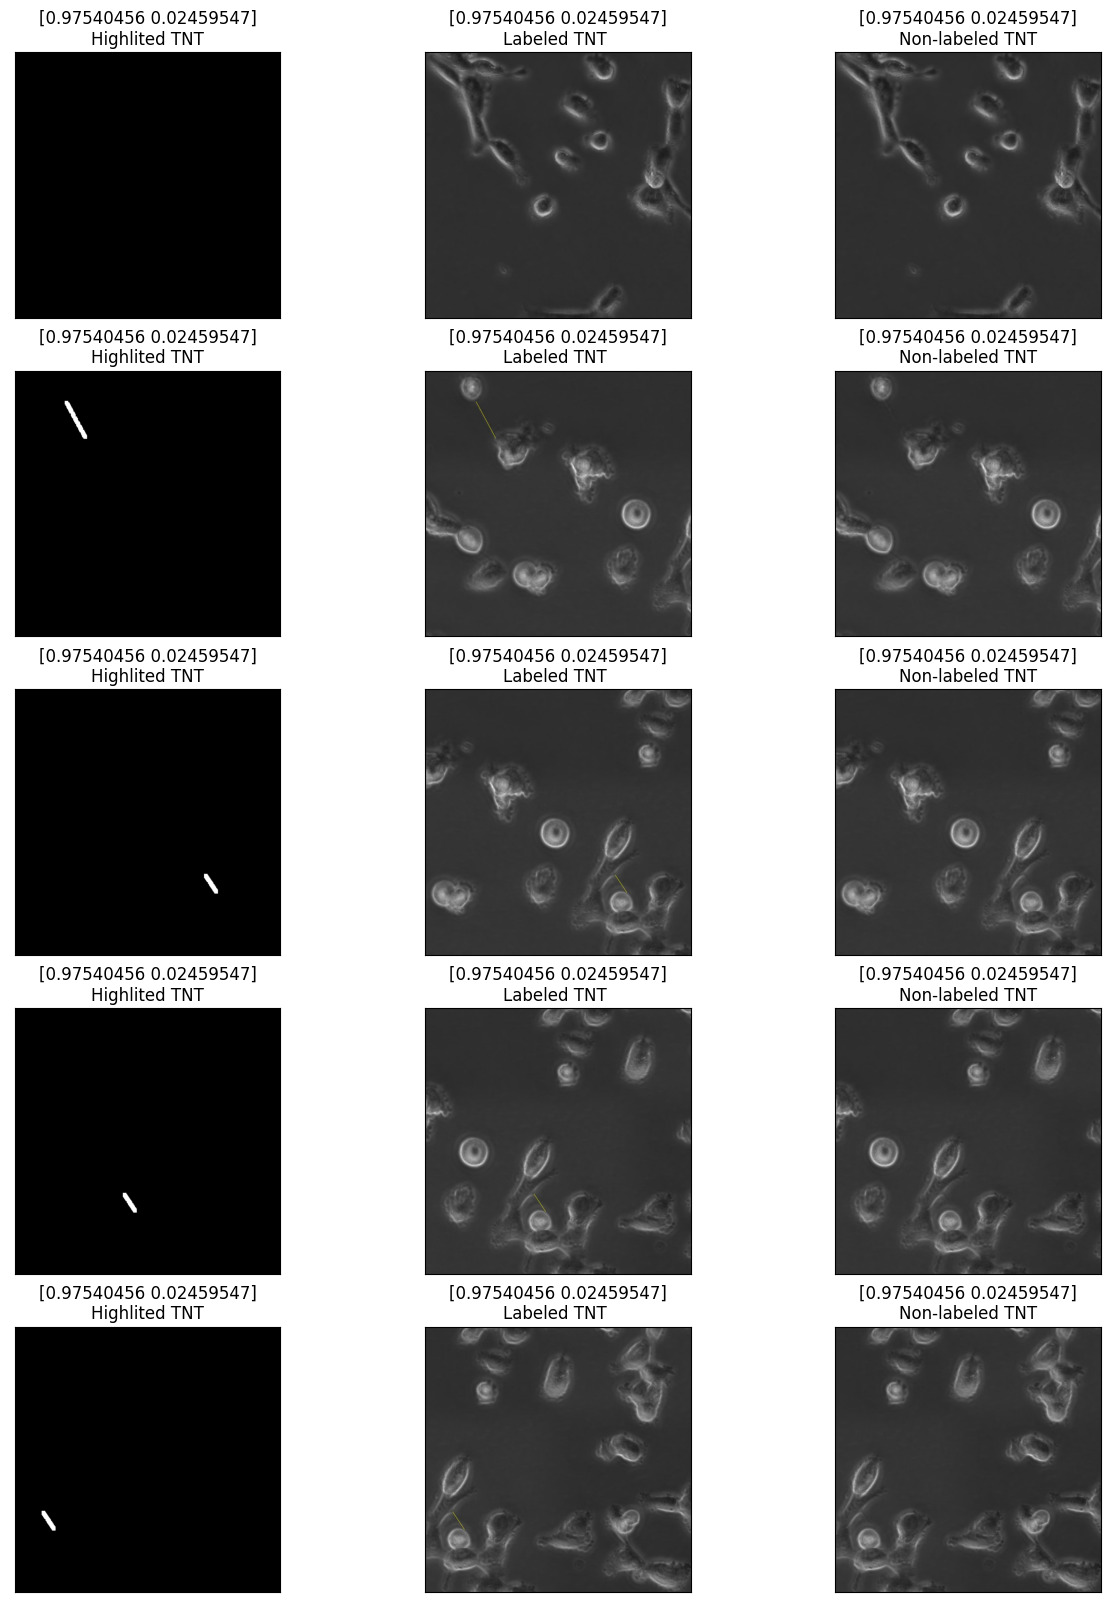

In [41]:
plot_predict_multiple_images(range(30000,30050,10), model_custom)

* Predictions on a full train image.

In [42]:
# calculate the number of pieces in the width of the image
def calculate_pieces_in_width_and_hight(img, piece_size, shift):
    x = 0
    y = 0
    pieces_width = 0
    pieces_height = 0
    while x + piece_size < img.shape[1]:
        pieces_width += 1
        x += shift
    while y + piece_size < img.shape[0]:
        pieces_height += 1
        y += shift
    return (pieces_width, pieces_height)

pieces = calculate_pieces_in_width_and_hight(img_rgb, 819, 25)
print(pieces)

(219, 155)


In [ ]:
predictions = []
for i, name in enumerate(df['Pic_name']):
    if i % 5 == 0:
        print(name)
        img = cv2.imread(os.path.join(DATADIR, name))
        prediction = model_custom.predict(img.reshape(-1, 819,819,3), verbose=0)
        predictions.append(prediction[0][0])
        if i%5000 == 0 and i != 0:
            print('5000 images predicted')
    else: 
        predictions.append(np.nan)

In [47]:
len(predictions)

33945

In [48]:
df['Prediction'] = predictions
df['Prediction'].value_counts()

9.754046e-01    5462
0.000000e+00     254
1.000000e+00     219
9.999999e-01       9
9.999996e-01       3
                ... 
9.962302e-01       1
2.911224e-10       1
9.999839e-01       1
6.379987e-20       1
9.997301e-01       1
Name: Prediction, Length: 840, dtype: int64

In [32]:
# save df with predictions
# df.to_csv(os.path.join(MAINDIR,r'CNN128x64x32xDense32_Predictions.csv'), index=False)

# load df with predictions
df = pd.read_csv(os.path.join(MAINDIR,r'CNN128x64x32xDense32_Predictions.csv'))
df['Prediction'] = np.where(df['Prediction'].isnull(), 'skip', df['Prediction'])
df.head()


,Pic_name,Label,Prediction
0,819-25-pic_0_label_2.jpg,2,0.9754045605659484
1,819-25-pic_1_label_2.jpg,2,skip
2,819-25-pic_2_label_0.jpg,0,skip
3,819-25-pic_3_label_0.jpg,0,skip
4,819-25-pic_4_label_0.jpg,0,skip


In [59]:
def create_for_merge_images(df):
    """Merges many images into one image.
    Highlight if image predicted as TNT.
    """
    for image in df.itertuples():

        path = os.path.join(DATADIR, image[1])
        
        if image[3] == 'skip':
            img = ''
        else:
            img = Image.open(path)

        # save image to folder
        if type(img) == str:
            with open(os.path.join(MAINDIR, 'Images_for_final_image', image[1] + '.empty'), 'w') as f:
                f.write(img)
        else:
            img.save(os.path.join(MAINDIR, 'Images_for_final_image', image[1]))
            img.close()
          



def merge_images(df):
    result = Image.new('RGB', (6278, 4690), color='white')
    # paste all pictures from  the list into one image with shift 25 pixels
    x = 0
    y = 0
    for image in df.itertuples():
        
        if image[3] == 'skip':
            pass
        else:
            if float(image[3]) > 0.5:
                img = cv2.imread(os.path.join(MAINDIR, 'Images_for_final_image', image[1]))
                # draw vertical lines on the image with space of 10 pixels and width of 1 pixel
                for i in range(0, img.shape[1], 25):
                    cv2.line(img, (i, 0), (i, img.shape[0]), (255,255,0), 1)
                # draw horizontal lines on the image with space of 10 pixels and width of 1 pixel
                for i in range(0, img.shape[0], 25):
                    cv2.line(img, (0, i), (img.shape[1], i), (255,255,0), 1)
                
                img = Image.fromarray(img)
            else:
                img = Image.open(os.path.join(MAINDIR, 'Images_for_final_image', image[1]))

            result.paste(img, (x, y))
            img.close()
        
        x += 25
        if x+819 > 6278:
            x = 0
            y += 25    
        
    
    return result

In [19]:
# create_for_merge_images(df)

In [60]:
final_prediction_image = merge_images(df)
final_prediction_image.save(os.path.join(MAINDIR, 'final_prediction_image.jpg'))

In [61]:
img = Image.open(os.path.join(MAINDIR, 'final_prediction_image.jpg'))
img.show()

#### Final predictions 
* As we can see model still needs improvement. But we have a good start and a template to experiment.
<center> Our Final Image with predictions </center>
-----------------------------------------------------------------------------------------------------------------------------------
<center><img src="..\TNT Project\final_prediction_image.jpg" alt="Alternative text" /></center>